https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [ ]:
import numpy as np
import pandas as pd
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Rescaling
import tensorflow as tf
import os
from keras import layers
from keras.models import Sequential
from keras import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
# Rutas locales
train_dir = r'C:\Users\LENOVO\Documents\DataVM\Cursos\DL_BED_2024-20241218T074932Z-001\DL_BED_2024\scripts\EjemploRadiografias_Neumonia\archive (1)\chest_xray\train'
val_dir = r'C:\Users\LENOVO\Documents\DataVM\Cursos\DL_BED_2024-20241218T074932Z-001\DL_BED_2024\scripts\EjemploRadiografias_Neumonia\archive (1)\chest_xray\val'
test_dir = r'C:\Users\LENOVO\Documents\DataVM\Cursos\DL_BED_2024-20241218T074932Z-001\DL_BED_2024\scripts\EjemploRadiografias_Neumonia\archive (1)\chest_xray\test'

# Cargar datasets de imágenes desde directorios locales
def load_dataset(directory):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',  # Las carpetas (normal, pneumonia) se usan como etiquetas
        color_mode='grayscale',
        batch_size=32,
        image_size=(256, 256),
        shuffle=True
    )

train_ds = load_dataset(train_dir)
val_ds = load_dataset(val_dir)
test_ds = load_dataset(test_dir)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
# Función para contar imágenes de cada clase en un dataset
def count_classes(dataset):
    class_counts = {0: 0, 1: 0}

    for images, labels in dataset:
        for label in labels.numpy():  # Convertir a numpy para poder trabajar con etiquetas
            class_counts[label] += 1

    return class_counts

# Contar las clases en cada conjunto de datos
train_class_counts = count_classes(train_ds)
val_class_counts = count_classes(val_ds)
test_class_counts = count_classes(test_ds)

print(f"Clases en train_ds: {train_class_counts}")
print(f"Clases en val_ds: {val_class_counts}")
print(f"Clases en test_ds: {test_class_counts}")

Clases en train_ds: {0: 1341, 1: 3875}
Clases en val_ds: {0: 8, 1: 8}
Clases en test_ds: {0: 234, 1: 390}


TOTAL IMAGENES: 5856

    TRAIN: 5216 (89%)

        0 (NORMAL): 25%

        1 (PNEUMONIA): 75%

    VAL: 16 (0.5%)

        0: 50%

        1: 50%

    TEST: 624 (10.5%)

        0: 38%

        1: 62%

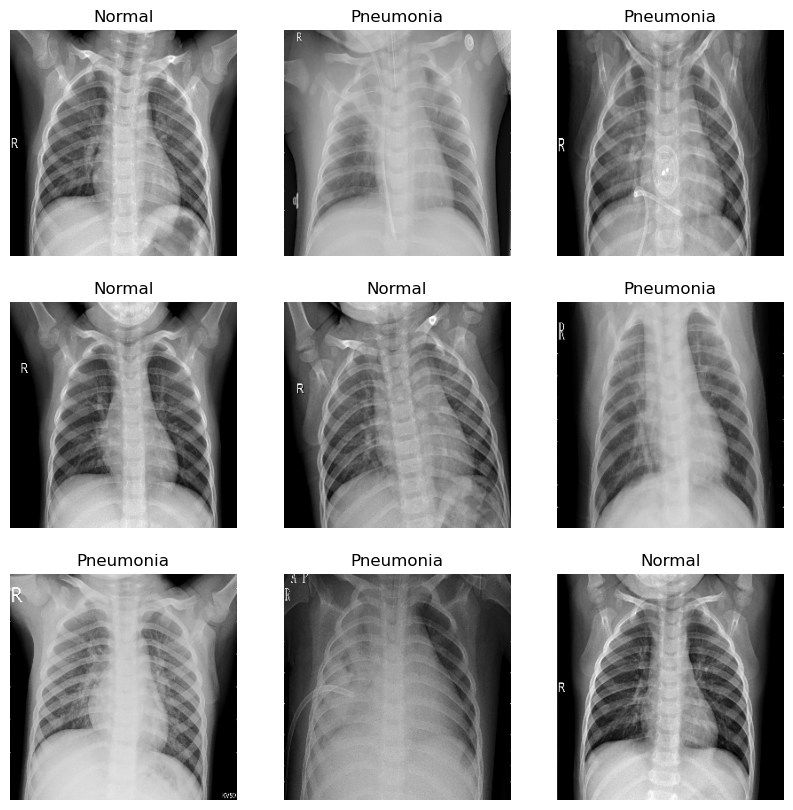

In [ ]:
# Mostrar algunas imágenes de ejemplo
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title('Normal' if labels[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.show()

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

cache(): Si el dataset cabe en memoria, almacena los datos localmente después de la primera carga. Esto mejora el rendimiento, ya que el dataset no tiene que leerse de nuevo desde el disco cada vez que se accede a los lotes.

prefetch(): Acelera el proceso al cargar los datos en segundo plano mientras el modelo entrena.

In [ ]:
model = Sequential([
    Input(shape=(256, 256, 1)),
    layers.Rescaling(1./255),  # Normalización de los valores de píxeles
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Función de pérdida para clasificación binaria
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,473 (14.14 MB)

 Trainable params: 3,705,473 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
# model_checkpoint: se encarga de guardar el mejor modelo de manera automática durante el proceso de entrenamiento
model_checkpoint = ModelCheckpoint('C:/Users/LENOVO/Documents/DataVM/Cursos/DL_BED_2024-20241218T074932Z-001/DL_BED_2024/scripts/EjemploRadiografias_Neumonia/mod_neumonia.keras', monitor='val_accuracy', save_best_only=True) #save_best_only: guarda el mejor resultado

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 520ms/step - accuracy: 0.8530 - loss: 0.3251 - val_accuracy: 0.8750 - val_loss: 0.3836
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 483ms/step - accuracy: 0.9684 - loss: 0.0904 - val_accuracy: 0.9375 - val_loss: 0.1365
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 478ms/step - accuracy: 0.9738 - loss: 0.0753 - val_accuracy: 0.6250 - val_loss: 0.6290
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 473ms/step - accuracy: 0.9715 - loss: 0.0765 - val_accuracy: 0.9375 - val_loss: 0.2265
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 466ms/step - accuracy: 0.9807 - loss: 0.0570 - val_accuracy: 0.9375 - val_loss: 0.1100
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 468ms/step - accuracy: 0.9865 - loss: 0.0371 - val_accuracy: 1.0000 - val_loss: 0.0323
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 474ms/step - accuracy: 0.9898 - loss: 0.0275 - val_accuracy: 0.9375 - val_loss: 0.0845
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 478ms/step - accuracy: 0.9897 - loss: 0

In [ ]:
# Cargar el mejor modelo guardado durante el entrenamiento
mejor_modelo = tf.keras.models.load_model('C:/Users/LENOVO/Documents/DataVM/Cursos/DL_BED_2024-20241218T074932Z-001/DL_BED_2024/scripts/EjemploRadiografias_Neumonia/mod_neumonia.keras')

In [ ]:
predicciones = mejor_modelo.predict(test_ds)
mejor_modelo.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.7407 - loss: 1.6153


[1.6693243980407715, 0.7403846383094788]

In [ ]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

predicciones_clase = (predicciones > 0.5).astype(int)
recall = recall_score(y_true, predicciones_clase)
precision = precision_score(y_true, predicciones_clase)
print(f"Recall: {recall:.4f}")
print(f"Precisión: {precision:.4f}")

Recall: 0.9974
Precisión: 0.7073


Aunque el recall es muy alto (lo que sugiere que el modelo está detectando correctamente los casos de pneumonia), la precisión indica que el modelo podría estar haciendo demasiados falsos positivos, especialmente para la clase normal. Esto puede deberse a un desbalance de clases en los datos de test, donde una mayor proporción de casos de pneumonia puede estar llevando al modelo a predecir pneumonia más a menudo.